In [28]:
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import DataLoader,TensorDataset
import torch.nn.functional as F
import torch.nn as nn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
import random as rand
from sklearn.preprocessing import LabelEncoder
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [2]:
def projector_fn(input_dim=16, proj_dim=128, hidden_dim=256):
    return nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, proj_dim)
    )

# Predictor: small MLP (only online network has this)
def predictor_fn(proj_dim=128, hidden_dim=256):
    return nn.Sequential(
        nn.Linear(proj_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, proj_dim)
    )

In [3]:
class Online(nn.Module):
    def __init__(self, dae_encoder, output_size=16, proj_dim=128, hidden_dim=256):
        super().__init__()
        self.encoder = dae_encoder   # use pretrained DAE encoder
        self.projector = projector_fn(output_size, proj_dim)
        self.predictor = predictor_fn(proj_dim)

    def forward(self, x, return_features=False):
        h = self.encoder(x)                # use DAE encoder
        z = self.projector(h)
        p = self.predictor(z)
        if return_features:
            return h
        return z, p

In [4]:
class Target(nn.Module):
    def __init__(self, dae_encoder, output_size=16, proj_dim=128, hidden_dim=256):
        super().__init__()
        self.encoder = dae_encoder         # use DAE encoder
        self.projector = projector_fn(output_size, proj_dim)

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        return z


## the importe dae

In [5]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=16):
        super(DenoisingAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # assuming features normalized [0,1]
        )
        
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out 

In [6]:
dae = DenoisingAutoencoder(input_dim=22, hidden_dim=64, latent_dim=16)
dae.encoder.load_state_dict(torch.load("/kaggle/input/encoder/pytorch/default/1/dae_encoder.pth",map_location=torch.device("cpu")))


<All keys matched successfully>

## now we train byol

In [7]:
def noisify(data):
    data = data.copy()
    np.random.seed(42)

    # Random packet loss or dropped features
    nb_features = len(data.columns)
    num_drops = rand.randint(1, 3)

    # the indexes to the random drops
    drop_indices = np.random.randint(0, nb_features, size=(len(data), num_drops))

    # cool way to do it
    rows = np.repeat(np.arange(len(data)), num_drops)
    cols = drop_indices.flatten()
    data.values[rows, cols] = np.nan  # when i do nan it gets me erro later , until i figure out how
                                # not have to deal with that and fix the masked loss function IT IS STAYING 0000

    # Swapping Source/Destination IPs
    # fixed sprint2 no changing column places
    # Randomly pick 10% of rows to swap
    mask = np.random.rand(len(data)) < 0.1
    data.loc[mask, ['SrcAddr', 'DstAddr']] = data.loc[mask, ['DstAddr', 'SrcAddr']].values

    # Changing Protocol Numbers (TCP → UDP)
    protocol_map = {6: 17, 17: 6}  # TCP <-> UDP
    # Apply noise to 5-10% of rows
    mask = np.random.rand(len(data)) < 0.05
    data.loc[mask, 'Proto'] = data.loc[mask, 'Proto'].map(lambda x: protocol_map.get(x, x))

    # Slightly Modifying Packet Lengths or Time Intervals
    # fixed sprint2 those tow lignes are useless
    # data['packet_length'] = data['TotBytes'] / data['TotPkts']
    # data['packet_length'].replace(np.nan,0)
    noise_fraction = 0.05
    mask = np.random.rand(len(data)) < 0.1  # apply to 10% of rows
    # data['packet_length'] = data['TotBytes'] / data['TotPkts']
    data.loc[mask, 'packet_length'] = data.loc[mask, 'packet_length'] * (
        1 + np.random.uniform(-noise_fraction, noise_fraction, mask.sum())
    )

    # Modify timestamps by a small jitter
    # to fix see if keep adjusted time per second only or more
    # just in seconds cause minute +- is too much
    time_jitter = 2  # seconds
    mask = np.random.rand(len(data)) < 0.1
    data.loc[mask, 'second'] = data.loc[mask, 'second'] + np.random.uniform(
        -time_jitter, time_jitter, mask.sum()
    )

    # feature level noise
    row_noise_fraction = 0.1  # 10%
    # Standard deviation as a fraction of the original value
    std_fraction = 0.05  # ±5%
    for col in data.columns:
        mask = np.random.rand(len(data)) < row_noise_fraction
        noise = data.loc[mask, col] * np.random.normal(0, std_fraction, mask.sum())
        data.loc[mask, col] = data.loc[mask, col] + noise

    return data


In [8]:
data=pd.read_csv("/kaggle/input/ctu-13/CTU_13.csv")
le = LabelEncoder()
lst = []
for i in data['Label']:
        if 'Botnet' in i:
            lst.append(1)
        elif 'Normal' in i:
            lst.append(2)
        else:
            lst.append(0)
data['Label']=lst


/tmp/ipykernel_36/3316103683.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv("/kaggle/input/ctu-13/CTU_13.csv")


In [15]:

data=data[data['Label']!=0]
direction_number = []
for i in data['Dir']:
        if i == '  <->':
            direction_number.append(1)
        elif i == '   ->':
            direction_number.append(2)
        else:
            direction_number.append(0)
data['Dir'] = direction_number
dataset=data.drop(columns=['Unnamed: 0'],inplace=False)
dataset.dropna(inplace=True)
dt = pd.to_datetime(dataset['StartTime'], format='%Y/%m/%d %H:%M:%S.%f')
df = pd.DataFrame({'datetime': dt})
dataset['year'] = df['datetime'].dt.year
dataset['month'] = df['datetime'].dt.month
dataset['day'] = df['datetime'].dt.day
dataset['hour'] = df['datetime'].dt.hour
dataset['minute'] = df['datetime'].dt.minute
dataset['second'] = df['datetime'].dt.second
dataset['dayofweek'] = df['datetime'].dt.dayofweek  # Monday=0, Sunday=6
dataset['is_weekend'] = dataset['dayofweek'].isin([5,6]).astype(int)
dataset.drop(columns=['StartTime'],inplace=True)
#fixed sprint2 added the packetlength column
dataset['packet_length'] = dataset['TotBytes'] / dataset['TotPkts']
cat_cols=['Proto','SrcAddr','DstAddr','Dport','State']
for col in cat_cols:
     if col in dataset.columns:
        numeric_labels = le.fit_transform(dataset[col])
        dataset[col]=numeric_labels
numeric_labels = le.fit_transform(dataset['Sport'].astype('str'))
dataset['Sport']=numeric_labels
total_len = len(dataset)
datasetlabeled=dataset.copy()
dataset.drop(columns=['Label'],inplace=True)
# 80% for encoder (unlabeled)
encoder_data = dataset[:int(total_len * 0.8)]
# Next 10% for linear classifier training (labeled)
lineardata = datasetlabeled[int(total_len * 0.8):int(total_len * 0.9)]
# Final 10% for evaluation (labeled)
datasetevaluation = datasetlabeled[int(total_len * 0.9):]



In [16]:
train_encoder=noisify(pd.DataFrame(encoder_data))

/tmp/ipykernel_36/654791944.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[57.04457953  2.16558829  1.31583833 ... 45.56573818 47.47018008
 47.66112551]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  data.loc[mask, 'second'] = data.loc[mask, 'second'] + np.random.uniform(
/tmp/ipykernel_36/654791944.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.08010651 2.92283851 2.05082974 ... 3.0087721  2.96956572 2.83143184]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[mask, col] = data.loc[mask, col] + noise
/tmp/ipykernel_36/654791944.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.84550185  1.94908862  7.67722591 ... 11.97816361 1

In [17]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

encoder_data = scaler.fit_transform(encoder_data)
train_encoder = scaler.fit_transform(train_encoder)

In [18]:
X_tensor = torch.tensor(encoder_data, dtype=torch.float32) 
X_tensor2 = torch.tensor(train_encoder, dtype=torch.float32) 

In [19]:
flow_dataset = TensorDataset(X_tensor,X_tensor2) 
dataloader = DataLoader(flow_dataset, batch_size=256, shuffle=True)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [22]:
onlinenn=Online(dae.encoder).to(device)
targetnn=Target(dae.encoder).to(device)

In [23]:
optimizeronline = torch.optim.Adam(list(onlinenn.parameters()) , lr=1e-3)


In [24]:


@torch.no_grad()
def update_target(online, target, m=0.99):  # momentum = 0.99
    for param_o, param_t in zip(online.parameters(), target.parameters()):
        param_t.data = m * param_t.data + (1 - m) * param_o.data
def byol_loss(p, z): #negative cosine similarity (official BYOL paper)
    p = F.normalize(p, dim=-1)
    z = F.normalize(z, dim=-1)
    return - (p * z).sum(dim=-1).mean()

In [26]:
epochs=20
for epoch in range(epochs):
    totalloss=0
    for batch,batchnoise in dataloader:
        batch = batch.to(device)
        batchnoise = batchnoise.to(device)
        x1, x2 = batch,batchnoise

        
        z1, p1 = onlinenn(x1)
        z2, p2 = onlinenn(x2)
        t1 = targetnn(x1)
        t2 = targetnn(x2)
        
        loss = 0.5 * (byol_loss(p1, t2) + byol_loss(p2, t1))
        #before this i was just adding both losses 
        #of prediction true from noise and noise from true and they were being added
        #whcih was putting the loss up tp -2 while is shouldnt get that high
        #that is why /2
        
        optimizeronline.zero_grad()
        loss.backward()
        optimizeronline.step()
        update_target(onlinenn, targetnn)
        totalloss+=loss
    avgloss=totalloss/(len(dataloader))
    print(f"Epoch {epoch+1} loss {avgloss}")

Epoch 1 loss -0.9917208552360535
Epoch 2 loss -0.9992097020149231
Epoch 3 loss -0.9993928670883179
Epoch 4 loss -0.9995599389076233
Epoch 5 loss -0.9996100664138794
Epoch 6 loss -0.9996938109397888
Epoch 7 loss -0.999742329120636
Epoch 8 loss -0.9998102188110352
Epoch 9 loss -0.9998184442520142
Epoch 10 loss -0.9998242855072021
Epoch 11 loss -0.9998067617416382
Epoch 12 loss -0.9998812079429626
Epoch 13 loss -0.9998728036880493
Epoch 14 loss -0.999874472618103
Epoch 15 loss -0.9998894333839417
Epoch 16 loss -0.9998894929885864
Epoch 17 loss -0.9998913407325745
Epoch 18 loss -0.9999082088470459
Epoch 19 loss -0.9999046325683594
Epoch 20 loss -0.999889075756073


for the loss we are using , avertage training loss of -0.9 is good , but!!!! is it actually learning or it collapsed we dont wantt the input to map the same victor , we want the encoder to preserve leaningful differences between inputs 

## verifying ssl part 

In [27]:

batch, _ = next(iter(dataloader))
batch = batch.to(device)

with torch.no_grad():
    z, _ = onlinenn(batch)  

# we check variance
print("Mean variance across features:", z.var(dim=0).mean().item())


Mean variance across features: 3.682904005050659


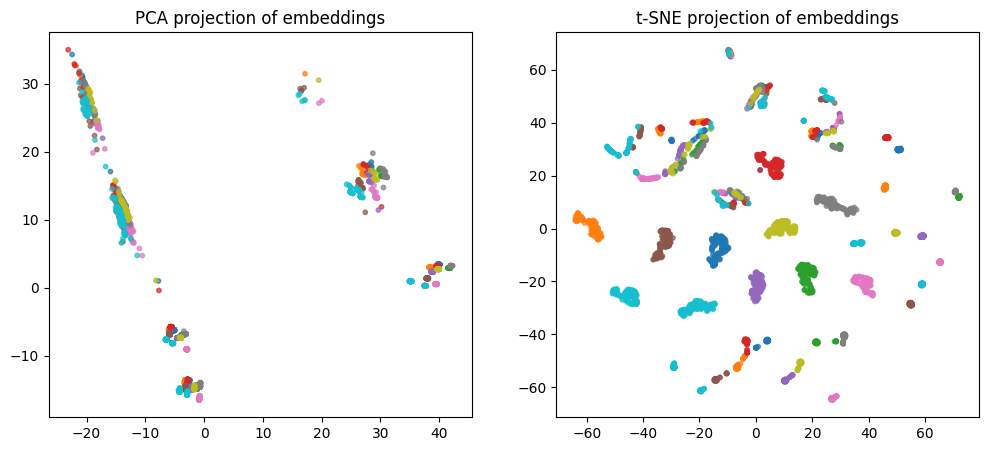

In [29]:


# 1. Collect embeddings for a few batches
all_embeddings = []
all_labels = []   # if you have labels (optional)

for i, (batch, _) in enumerate(dataloader):
    batch = batch.to(device)
    with torch.no_grad():
        z, _ = onlinenn(batch)
    all_embeddings.append(z.detach().cpu().numpy())
    # if you have labels, append them here instead of "_"
    all_labels.extend([i]*len(batch))  
    if i == 10:   # limit to ~10 batches for speed
        break

import numpy as np
all_embeddings = np.vstack(all_embeddings)

# 2. PCA projection
pca = PCA(n_components=2)
emb_pca = pca.fit_transform(all_embeddings)

# 3. t-SNE projection (slower but often clearer)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_tsne = tsne.fit_transform(all_embeddings)

# 4. Plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(emb_pca[:,0], emb_pca[:,1], s=10, alpha=0.7, c=all_labels, cmap='tab10')
plt.title("PCA projection of embeddings")

plt.subplot(1,2,2)
plt.scatter(emb_tsne[:,0], emb_tsne[:,1], s=10, alpha=0.7, c=all_labels, cmap='tab10')
plt.title("t-SNE projection of embeddings")

plt.show()


### PCA
the embeddings have not collapsed , they are spread into an axix and a cluster ,(psa is linear btw)
### t-SNE
tsne is non linear , so it will put emphasis on the local neighborhood struc, each group is a bunch of samples with simliair embeddings

## testing with a supervised model

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)


In [33]:
X_labeled=lineardata.drop(columns=['Label'],inplace=False)
y_labels=lineardata['Label']
y_labels = torch.tensor(y_labels.values, dtype=torch.long)

In [34]:
unique_labels = torch.unique(y_labels)
label_map = {old.item(): new for new, old in enumerate(unique_labels)}
y_labels = torch.tensor([label_map[int(l)] for l in y_labels], dtype=torch.long).to(device)
X_tensor = torch.tensor(X_labeled.values, dtype=torch.float32).to(device)
      

In [35]:
label_map

{1: 0, 2: 1}

In [36]:
with torch.no_grad():
    embeddings = onlinenn(X_tensor,True)

In [37]:
y_labels = y_labels.detach().cpu().numpy()
rf.fit(embeddings.detach().cpu().numpy(), y_labels)


RandomForestClassifier(random_state=42)

In [38]:
datasetevaluation['Label'].unique()
datasetevaluation=datasetevaluation.dropna()

In [39]:
datasetevaluation = datasetevaluation.dropna(subset=['Label'])
X_eval = datasetevaluation.drop(columns=['Label']).select_dtypes(include=[np.number])
label_map = {1: 0, 2: 1}
y_labels = data['Label'].map(label_map)
y_eval  = datasetevaluation['Label'].map(label_map)


In [40]:
X_eval_tensor = torch.tensor(X_eval.values, dtype=torch.float32).to(device)
with torch.no_grad():
    eval_embeddings = onlinenn.encoder(X_eval_tensor).cpu().numpy()


In [41]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = rf.predict(eval_embeddings)


In [42]:

print("Accuracy:", accuracy_score(y_eval, y_pred))
print("Classification Report:\n", classification_report(y_eval, y_pred))

Accuracy: 0.9391794817219178
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     27352
           1       0.91      0.97      0.94     29027

    accuracy                           0.94     56379
   macro avg       0.94      0.94      0.94     56379
weighted avg       0.94      0.94      0.94     56379



AUROC: 0.9845578443406056


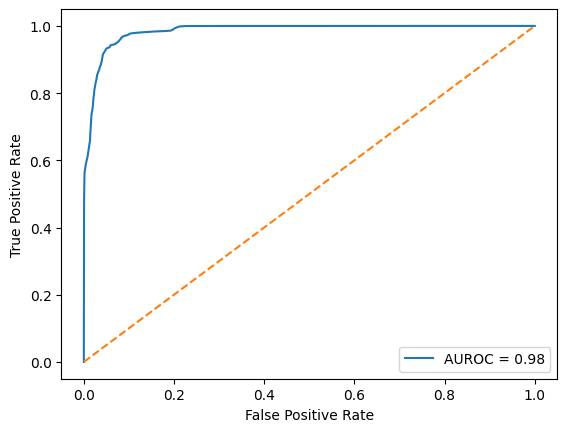

In [43]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# y_eval: ground truth labels (0/1)
# rf: your RandomForestClassifier

# Get predicted probabilities for the positive class
y_proba = rf.predict_proba(eval_embeddings)[:, 1]

# Compute AUROC
auroc = roc_auc_score(y_eval, y_proba)
print("AUROC:", auroc)

# Optional: Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_eval, y_proba)
plt.plot(fpr, tpr, label=f"AUROC = {auroc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")  # random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

AUPRC: 0.9835286818632529


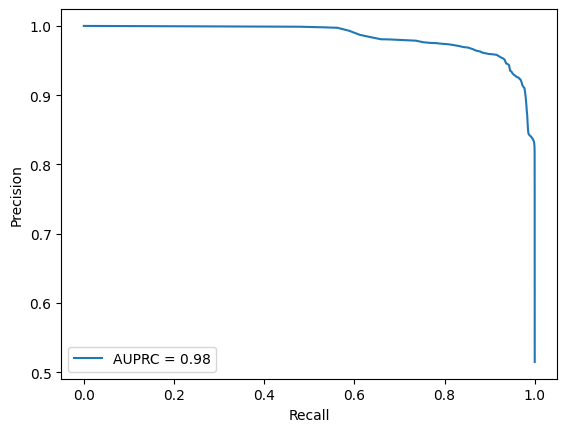

In [44]:
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt

# y_eval: ground truth (0/1)
# rf: your trained RandomForestClassifier

# Probabilities for the positive class
y_proba = rf.predict_proba(eval_embeddings)[:, 1]

# AUPRC
auprc = average_precision_score(y_eval, y_proba)
print("AUPRC:", auprc)

# Precision–Recall curve
precision, recall, thresholds = precision_recall_curve(y_eval, y_proba)

plt.plot(recall, precision, label=f"AUPRC = {auprc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


In [45]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# y_eval: ground truth labels
# y_pred: predicted labels from rf.predict

# Accuracy
acc = accuracy_score(y_eval, y_pred)
print("Accuracy:", acc)

# F1-score (binary)
f1 = f1_score(y_eval, y_pred)
print("F1-score:", f1)

# Optional: for multi-class or detailed metrics
print("Classification Report:\n", classification_report(y_eval, y_pred))


Accuracy: 0.9391794817219178
F1-score: 0.9427287759090074
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     27352
           1       0.91      0.97      0.94     29027

    accuracy                           0.94     56379
   macro avg       0.94      0.94      0.94     56379
weighted avg       0.94      0.94      0.94     56379



In [46]:
import numpy as np

# y_eval: ground truth (0 = normal, 1 = botnet)
# y_proba: predicted probability for the positive class (from rf.predict_proba)

k = 50  # top 50 predictions
topk_idx = np.argsort(y_proba)[-k:]  # indices of top k probabilities
topk_true = y_eval.iloc[topk_idx]    # corresponding true labels

precision_at_k = topk_true.sum() / k  # number of positives in top k / k
print(f"Precision@{k}:", precision_at_k)


Precision@50: 1.0


In [47]:
y_proba = rf.predict_proba(eval_embeddings)[:, 1]  # correct


In [48]:
from sklearn.metrics import roc_curve
import numpy as np

target_fpr = 0.01
fpr, tpr, thresholds = roc_curve(y_eval, y_proba)

# Clip FPR to ensure the closest threshold is in range
idx = np.argmin(np.abs(fpr - target_fpr))
print(f"TPR at FPR={target_fpr*100:.2f}%: {tpr[idx]:.3f}")
print(f"Threshold used: {thresholds[idx]:.3f}")


TPR at FPR=1.00%: 0.635
Threshold used: 0.950


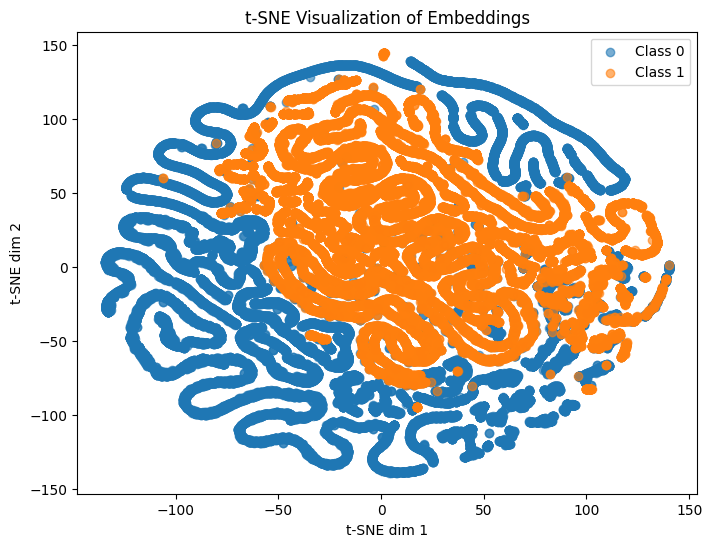

In [49]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# eval_embeddings: your high-dimensional embeddings (numpy array)
# y_eval: labels

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(eval_embeddings)

plt.figure(figsize=(8,6))
for label in np.unique(y_eval):
    idx = y_eval == label
    plt.scatter(emb_2d[idx,0], emb_2d[idx,1], label=f"Class {label}", alpha=0.6)
plt.legend()
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.show()


2025-09-27 15:35:55.742714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758987355.940143      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758987355.998271      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


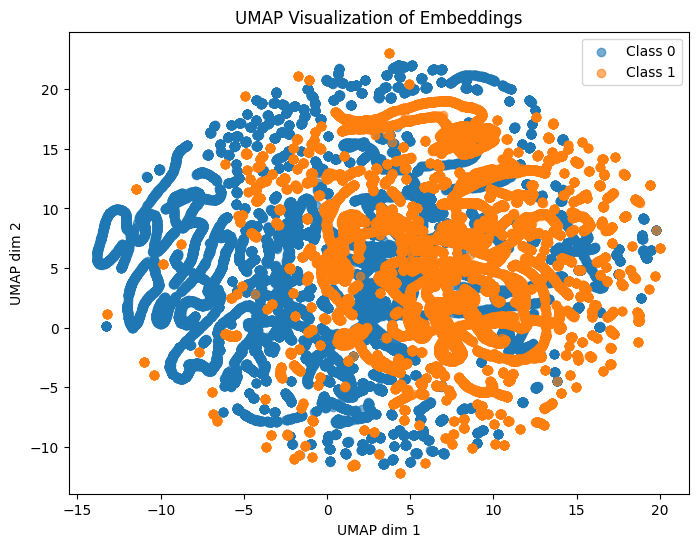

In [50]:
import umap

reducer = umap.UMAP(n_components=2, random_state=42)
emb_2d = reducer.fit_transform(eval_embeddings)

plt.figure(figsize=(8,6))
for label in np.unique(y_eval):
    idx = y_eval == label
    plt.scatter(emb_2d[idx,0], emb_2d[idx,1], label=f"Class {label}", alpha=0.6)
plt.legend()
plt.title("UMAP Visualization of Embeddings")
plt.xlabel("UMAP dim 1")
plt.ylabel("UMAP dim 2")
plt.show()


# ?????